In [198]:
!tree --dirsfirst -L 1

.
├── censored
├── models
├── output
├── SpeechCommands
├── swear_words
├── test
├── train
├── censored_Recording_3.wav
├── censor.wav
├── output.wav
├── pred.csv
├── Recording_3.wav
├── test.csv
└── train.csv

7 directories, 7 files


# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U fastai fastcore pydub ffmpy
!pip install torchaudio librosa
!pip install fastai
!pip install fastcore==1.3.26
!pip install -q git+https://github.com/fastaudio/fastaudio.git --upgrade

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:40tcmalloc: large alloc 1147494400 bytes == 0x564e1c4cc000 @  0x7fa3ed5b8615 0x564de34b24cc 0x564de359247a 0x564de34b52ed 0x564de35a6e1d 0x564de3528e99 0x564de35239ee 0x564de34b6bda 0x564de3528d00 0x564de35239ee 0x564de34b6bda 0x564de3525737 0x564de35a7c66 0x564de3524daf 0x564de35a7c66 0x564de3524daf 0x564de35a7c66 0x564de3524daf 0x564de34b7039 0x564de34fa409 0x564de34b5c52 0x564de3528c25 0x564de35239ee 0x564de34b6bda 0x564de3525737 0x564de35239ee 0x564de34b6bda 0x564de3524915 0x564de34b6afa 0x564de3524c0d 0x564de35239ee
     |████████████████████████████████| 881.9 MB 14 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's

     |████████████████████████████████| 831.4 MB 881 bytes/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 0.10.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.


     |████████████████████████████████| 56 kB 2.1 MB/s 
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.3.27
    Uninstalling fastcore-1.3.27:
      Successfully uninstalled fastcore-1.3.27
     |████████████████████████████████| 194 kB 5.4 MB/s 
     |████████████████████████████████| 1.9 MB 47.6 MB/s 
     |████████████████████████████████| 183 kB 54.5 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 804.1 MB 2.0 kB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 22.1 MB 57 kB/s 
     |████████████████████████████████| 22.1 MB 61 kB/s 
     |████████████████████████████████| 17.4 MB 113 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.1 which is incompatible.


In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import glob
from pydub import AudioSegment
from pathlib import Path
import os
from fastcore.parallel import parallel
import multiprocess as mp
import pandas as pd
import shutil
from fastai.vision import *
from fastaudio.core.all import *
from fastaudio.augment import *
from fastaudio.ci import skip_if_ci
from fastai.vision.all import *
from fastai.data.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
%cd /content/drive/MyDrive/AML_swear_word_detection

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


/content/drive/MyDrive/AML_swear_word_detection


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# SECTION 1 : Loading Data



In [ ]:
# !git clone https://github.com/theabuseproject/tapad swear_words

Cloning into 'swear_words'...
remote: Enumerating objects: 52900, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 52900 (delta 0), reused 0 (delta 0), pack-reused 52896
Receiving objects: 100% (52900/52900), 160.90 MiB | 9.90 MiB/s, done.
Resolving deltas: 100% (4091/4091), done.
Checking out files: 100% (26376/26376), done.


In [ ]:
#  function to play an audio file
def play_back(file):
  waveform, sample_rate = torchaudio.load(file)
  return ipd.Audio(waveform, rate = sample_rate)

In [ ]:
#  Convert mp3 files to wav
def to_wav_format(file):
  parent = Path(file).parent.name
  file_name = Path(file).stem + '.wav'
  mp3 = AudioSegment.from_mp3(file)
  output = Path(dir).parents[1]/parent/file_name
  os.remove(file)
  if Path(output).exists(): 
    os.remove(output)
  mp3.export(output, format="wav")

dir = 'swear_words/audio/en*/*.mp3'
files = glob.glob(dir)
parallel(to_wav_format, files, n_workers = mp.cpu_count())

In [ ]:
# Load swear words len = (4511 words)
swear_words = glob.glob("/content/drive/MyDrive/AML_swear_word_detection/swear_words/audio/en*/*.wav"); 
len(swear_words)

4511

### Check if TAPAD data is present


In [ ]:
# confirm swear words are present and loaded correctly
file = random.choice(swear_words)
print(file)
play_back(file)

/content/drive/MyDrive/AML_swear_word_detection/swear_words/audio/en-za/fuckbrain.wav


### Check if speech commands dataset is present

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS

class clean_audio_dataset(SPEECHCOMMANDS):
    def __init__(self): 
      super().__init__("./", download=True)        
clean_audio_dataset()


In [ ]:
# load speech_commands dataset len = (105835 words)
clean_words = glob.glob('/content/drive/MyDrive/AML_swear_word_detection/SpeechCommands/speech_commands_v0.02/*/*.wav')
print(len(clean_words))

105835


In [ ]:
# confirm clean words are present and loaded correctly
print(len(clean_words))
file = random.choice(clean_words)
print(file)
play_back(file)

105835
/content/drive/MyDrive/AML_swear_word_detection/SpeechCommands/speech_commands_v0.02/four/a4b21cbc_nohash_0.wav


In [ ]:
# Copy swear words and clean words to store in drive for faster loading
# !cp -r swear_words /content/drive/MyDrive/AML_swear_word_detection
# !cp -r /content/SpeechCommands /content/drive/MyDrive/AML_swear_word_detection

### Helper functions for loading data and creating directories for test and train data and further creating a dataframe for this data


In [ ]:
# Returns class of a file 0 or 1
def set_class(file_location):
  if 'speech_commands' in str(file_location):
    return 0 # label =0 if contains no swear words
  else:
    return 1 # label =1 if contains swear words

# Extract file name from file_location
def set_file_name(file_location):
  if 'speech_commands' in str(file_location):
    name = str(Path(file_location).parent.name)
  else:
    name = str(Path(file_location).stem)
  return name

# Creates a directory of name "directory_name"
def create_directory(directory_name): 
  if Path(directory_name).exists(): shutil.rmtree(directory_name)
  os.mkdir(directory_name)

# create a new file name according to specified directory file is placed in
def recreate_name(file_location, new_location):
  file_name = set_file_name(file_location) + str(Path(file_location).suffix)
  final_name = Path(new_location)/file_name
  return final_name

# copy file to new directory
def move_to_new_location(file_location, new_location):
  shutil.copyfile(file_location, recreate_name(file_location, new_location))

# Create a dataframe for train and test data and set target = class 0 or 1 
def create_dataframe(folder_name, data):
  print("Creating", folder_name)
  df = pd.DataFrame({'file_name': [recreate_name(i, folder_name) for i in data],
                      'target': [set_class(i) for i in data]})
  parallel(move_to_new_location, data, dir = folder_name, n_workers = mp.cpu_count()) # use parallel processing to speed things up
  return df

In [ ]:
# Split data into training and testing
def split_data(data, split = 0.8):
  random.shuffle(data)
  train_length = int(len(data) * 0.8)
  train_data = data[:train_length]
  test_data = data[train_length:]
  return train_data, test_data

# Create folders for test and train data and generate a dataframe for training the model
def create_train_test(split = 0.8):
  if Path('train.csv').exists() and Path('test.csv').exists(): 
    return pd.read_csv('train.csv'), pd.read_csv('test.csv')

  create_directory('test')
  create_directory('train')

  train_data, test_data = split_data(swear_words + clean_words, split)

  train_df = create_dataframe('train', train_data)
  test_df = create_dataframe('test', test_data)

  return train_df, test_df

train_df, test_df = create_train_test(0.8)
# train_df.head()
print(train_df.head())
#  reloading prediction_df
prediction_df = pd.read_csv('pred.csv')
print(prediction_df)

           file_name  target  fold
0  train/forward.wav       0     5
1      train/two.wav       0     5
2      train/off.wav       0     5
3      train/cat.wav       0     5
4      train/cat.wav       0     5
             file_name  actual  prediction
0         test/yes.wav       0           0
1          test/no.wav       0           0
2          test/no.wav       0           0
3      test/marvin.wav       0           0
4       test/three.wav       0           0
...                ...     ...         ...
22065      test/on.wav       0           0
22066   test/learn.wav       0           0
22067  test/visual.wav       0           0
22068      test/go.wav       0           0
22069    test/five.wav       0           0

[22070 rows x 3 columns]


I've used multiprocessing here to really speed things up. The `parallel` function from [`fastcore`](https://fastcore.fast.ai/parallel.html#parallel) is incredibly useful and saves me a lot of time.


In [ ]:
train_df['target'].value_counts()

0    84655
1     3621
Name: target, dtype: int64

In [ ]:
test_df['target'].value_counts()

0    21180
1      890
Name: target, dtype: int64

In [ ]:
# check if dataframe was made correctly
print (len(swear_words+clean_words)==(train_df['target'].value_counts().sum() + test_df['target'].value_counts().sum()))

True


In [ ]:
def generate_csv_files(dataframe_name, file_name):
  try: os.remove(file_name)
  except: pass
  dataframe_name.to_csv(file_name, index = False)

generate_csv_files(train_df, 'train.csv')
generate_csv_files(test_df, 'test.csv')

### Verify all files can be loaded from dataframe


In [ ]:
def verify_df_loading(df):
  i = random.randrange(0, df.shape[0])
  print(i)
  file = df.iloc[i]['file_name']
  print(type(file))
  print(df.iloc[i]['target'])
  print(file)
  w, sr = torchaudio.load(file)
  return ipd.Audio(w.numpy(), rate = sr)

In [ ]:
verify_df_loading(test_df)

12390
<class 'str'>
0
test/tree.wav


In [ ]:
verify_df_loading(train_df)

67707
<class 'str'>
0
train/right.wav


# SECTION 2: Preprocessing data



In [ ]:
# Helper function to split the data Picked from 1.
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

# create number of fold to be usind in
def generate_folds(iter, df):
  section = df.shape[0]//n_folds
  if (iter == 0): 
    return [1]
  return [iter]*section + generate_folds(iter - 1, df)

In [ ]:
n_folds = 5
train_df['fold'] = generate_folds(n_folds, train_df)
train_df

file_name  target  fold
0      train/forward.wav       0     5
1          train/two.wav       0     5
2          train/off.wav       0     5
3          train/cat.wav       0     5
4          train/cat.wav       0     5
...                  ...     ...   ...
88271    train/right.wav       0     1
88272   train/visual.wav       0     1
88273   train/marvin.wav       0     1
88274     train/zero.wav       0     1
88275       train/no.wav       0     1

[88276 rows x 3 columns]

In [ ]:
configuration = AudioConfig.BasicMelSpectrogram(n_fft=512, n_mels = 32) # 512 fourier transformations and filterbank =32
a2s = AudioToSpec.from_cfg(configuration)

In [ ]:
item_tfms = [ResizeSignal(500), Resample(8000), DownmixMono()]
batch_tfms = [a2s]

In [ ]:
# helper function to Load audio using datablock from fastaudio
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("file_name"), 
                 batch_tfms = batch_tfms,
                 item_tfms = item_tfms,
                 splitter = CrossValidationSplitter(col = 'fold', fold = 2),
                 get_y = ColReader("target"))

In [ ]:
batch_size = 64

In [ ]:
# load train_data
dbunch = auds.dataloaders(train_df, bs=batch_size)

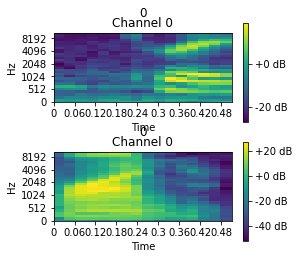

In [ ]:
# view data
dbunch.show_batch()

# SECTION 3 : Training model using transfer learning from ResNet18

In [ ]:
# Get resnet18 from fastai
metrics = [accuracy,F1Score]
learn = cnn_learner(dbunch,models.resnet18,n_in=1,loss_func=CrossEntropyLossFlat(),metrics=[metrics[1]])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 16 x 8    
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [199]:
# Train ResNet18 on train dataset
# from fastai.callback.tracker import SaveModelCallback
@skip_if_ci
def run_learner():
    learn.fine_tune(epochs = 10)
run_learner()

# LEARNING got completed and the outputs got ommited, however i had saved an image of the same and is presented in the presentation and the report

In [203]:
# Save the model after training
learn.save("speech_recognition_resnet18_model_v3")

Path('models/tmp2.pth')

In [201]:
#  loading the trained model
learn.load("speech_recognition_resnet18_model_v3")
learn.unfreeze()

# SECTION 4: Prediction 

In [ ]:
#  predict on testing data and store in prediction_df dataframe
tqdm.pandas()
prediction_df = test_df[['file_name', 'target']]
prediction_df['prediction'] = prediction_df['file_name'].progress_apply(lambda file: learn.predict(file)[0])
prediction_df.rename(columns = {'target': 'actual'}, inplace = True)
prediction_df.head()
#  Prediction was run again only on 1500 values just to re - confirm if dataset and model was loaded properly which explains 1500 in the below run bar. 
#  In the original run when the prediction_df was created and stored, it was run on the entire Test dataset

  0%|          | 0/1500 [00:00<?, ?it/s]

file_name  actual prediction
0     test/yes.wav       0          0
1      test/no.wav       0          0
2      test/no.wav       0          0
3  test/marvin.wav       0          0
4   test/three.wav       0          0

In [ ]:
#  check if prediction_df was created correctly and predictions were made
prediction_df['prediction'][:1500].value_counts()

0    1349
1     151
Name: prediction, dtype: int64

In [ ]:
prediction_df['actual'].value_counts()

0    21180
1      890
Name: actual, dtype: int64

In [ ]:
#  evaluating accuracy
prediction_df[prediction_df['actual'] == prediction_df['prediction'].astype(int)]

file_name  actual  prediction
0         test/yes.wav       0           0
1          test/no.wav       0           0
2          test/no.wav       0           0
3      test/marvin.wav       0           0
4       test/three.wav       0           0
...                ...     ...         ...
22065      test/on.wav       0           0
22066   test/learn.wav       0           0
22067  test/visual.wav       0           0
22068      test/go.wav       0           0
22069    test/five.wav       0           0

[20918 rows x 3 columns]

In [ ]:
prediction_df[(prediction_df['prediction'].astype(int)==1)].shape

(2042, 3)

In [ ]:
prediction_df[(prediction_df['actual']==1)].shape

(890, 3)

In [ ]:
#  store predictions as a csv file for later use
# generate_csv_files(prediction_df, 'pred.csv')

<class 'numpy.int64'>
<class 'numpy.int64'>
True negatives:  20028 
False positives:  1152 
False negatives:  0 
True Positives:  890


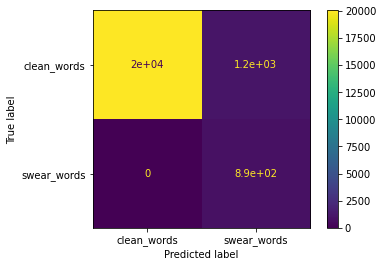

In [ ]:
#  Display confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
print(type(prediction_df['actual'][0]))
print(type(prediction_df['prediction'][0]))

tn, fp, fn, tp = confusion_matrix(prediction_df['actual'], prediction_df['prediction'].astype(int) ).ravel()
cm =confusion_matrix(prediction_df['actual'], prediction_df['prediction'].astype(int),labels=prediction_df['actual'].unique())
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue Positives: ', tp)
# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["clean_words","swear_words"])
disp.plot()
plt.show()

In [ ]:
#  display f1 score and accuracy
from sklearn.metrics import f1_score,accuracy_score
y_true = prediction_df['actual']
y_pred = prediction_df['prediction']
# print (type(y_true),type(y_pred))
f1 = f1_score(y_true, y_pred.astype(int),average='macro')
print ("F1 Score on testing data",f1)
accuracy = accuracy_score(y_true, y_pred)
print ("Accuracy on testing data",accuracy)

F1 Score on testing data 0.7895691984734947
Accuracy on testing data 0.9478024467603081


# SECTION 5 : Prediction on unseen audio 30 second clips

In [ ]:
import shutil
from pydub import AudioSegment
import os
from tqdm.notebook import trange

#  function to get length of file in milliseconds
def file_length(file):
  audio = AudioSegment.from_wav(file)
  return int(audio.duration_seconds * 1000)

# function to help splitting of files in parallel
def split_helper(i, file, folder, split_size):
  start_time = i 
  end_time = i + split_size
  output = Path(f'{folder}/audio_{i}{Path(file).suffix}')
  audio = AudioSegment.from_wav(file)
  audio[start_time:end_time].export(output, format=f'{Path(file).suffix[1:]}')
  
# function that makes use of split helper to return split files of testing audio
def get_split_files(file, folder = 'output', split_size = 1000):
  print("splitting testing audio file into",split_size/1000,"second files")
  folder = Path(folder)
  if folder.exists(): 
    shutil.rmtree(folder)
  os.mkdir(folder)
  total_size = file_length(file)
  parallel(split_helper, range(0, total_size, split_size), file = file, folder = folder, split_size = split_size)
  split_files = glob.glob(f'{folder}/audio*{Path(file).suffix}')
  split_files = sorted(split_files, key = lambda x: int(str(Path(x).stem).split('_')[-1]))
  return split_files

In [ ]:
split_size = 2000 # time in milliseconds
output_folder = 'output'
files = get_split_files(PREDICTION_FILE, output_folder , split_size)

splitting testing audio file into 2.0  second files


In [126]:
import ffmpy
from tqdm.notebook import trange

# function that censors all bad_words
# return censored file which is the same length as original file
def censor_words(file):
  ms = file_length(file)
  output = recreate_name(file,'censored')
  ffmpy.FFmpeg(inputs={str(CENSOR_FILE):''},\
               outputs={str(output): "-y -ss 00:00:00 -to 00:00:00."+str(ms)+' -c copy'}).run() 
  return output

# function that joins all split files and censor files to get back censored audio from original audio
def get_audio_back(files, file_name ):
  print("recreating audio file with censored bad words")
  print("get_audio_back",file_name)
  n = len(files)
  t = ''.join(['['+str(i)+':0]' for i in range(n)])
  ffmpy.FFmpeg(inputs={str(files[n-1]): "-y "+ " ".join(['-i ' + str(i) for i in files[:n-1]])},\
               outputs={file_name: "-filter_complex '"+str(t)+"concat=n="+str(n)+\
               ":v=0:a=1[out]' -map '[out]'"}).run()
    
  return file_name

# driver functionthat censors the input audio file
def censor(file, seconds = 0.2, folder = 'output'):
  create_directory('censored')
  ms = int(seconds * 1000)
  files = get_split_files(file, Path(folder), ms)
  
  for i in trange(len(files)):
    pred = learn.predict(files[i])[0]
    if (int(pred) == 1): 
      print(f'swear word identified')
      files[i] = censor_words(files[i])

  file_name = get_audio_back(files,'censored_' +Path(file).stem + Path(file).suffix)
  return file_name

In [127]:
#  get censor audio file which will replace curse words and profanity in the audio file PREDICTION_FILE
CENSOR_FILE = '/content/drive/MyDrive/AML_swear_word_detection/censor.wav'
#  set prediction file path here
PREDICTION_FILE = '/content/drive/MyDrive/AML_swear_word_detection/Recording_3.wav'
play_back(CENSOR_FILE)

In [130]:
print ('censored_' +Path(PREDICTION_FILE).stem + Path(file).suffix)

censored_Recording_3.wav


In [129]:
# CENSORING FILE
censored_file_wav = censor(PREDICTION_FILE, seconds = 0.2)

splitting testing audio file into 0.2  second files


  0%|          | 0/82 [00:00<?, ?it/s]

swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


swear word identified


recreating audio file with censored bad words
get_audio_back censored_Recording_3.wav


In [135]:
print ("File to be censored->",Path(PREDICTION_FILE))
play_back(PREDICTION_FILE)

File to be censored-> /content/drive/MyDrive/AML_swear_word_detection/Recording_3.wav


In [134]:
print("CENSORED FILE->",Path(censored_file_wav))
play_back(censored_file_wav)

CENSORED FILE-> censored_Recording_3.wav
